### Non-temporal Classification with LogisticRegression

Data preprocessing:
1. Categorical features have been OneHotEncoded
2. Target value vhigh was merged into high
3. Similar columns are mearged together
4. RobustScaler and QuantileTransformer have been applied in order to deal with ouliers

Model trainig:
1. l2 regularization was used to prevent over/under fitting

Results:
1. F1_score on test data: **61.28**
2. Included important features plot
3. Included confusion matrix


In [4]:
import pandas as pd
import numpy as np

In [5]:
df = pd.read_parquet('../../data/8. data_for_modelling/Non Temporal Datasets/train_nontemporal_classification.parquet.gz')
df.shape

(300960, 123)

In [6]:
from sklearn.preprocessing import LabelEncoder

# "OneHotEncode" categorial fetures
def encodeCategoricalFeatures(main_df):
    df = main_df.copy()

    df['holiday_name'] = LabelEncoder().fit_transform(df['holiday_name'])

    dummies = pd.get_dummies(df["season"], prefix="season")
    df = pd.concat([df, dummies], axis='columns')

    dummies = pd.get_dummies(df["voivodship"], prefix="voivodship")
    df = pd.concat([df, dummies], axis='columns')

    dummies = pd.get_dummies(df["powiat_voivod"])
    df = pd.concat([df, dummies], axis='columns')

    # dummies = pd.get_dummies(df["holiday_name"], prefix="holiday")
    # df = pd.concat([df, dummies], axis='columns')
    
    return df

# merge high and vhigh CAQI values
# replace ['vlow', 'low', 'medium', 'high', 'vhigh'] with [0, 1, 2, 3, 3]
def encodeTargetVariable(main_df):
    df = main_df.copy()
    df['CAQI_level'].replace(to_replace=['vlow', 'low', 'medium', 'high', 'vhigh'], value=[0, 1, 2, 3, 3], inplace=True)
    return df

# group similar cols together (and sum their values)
# https://github.com/OmdenaAI/warsaw-poland-chapter-air-pollution/blob/main/src/tasks/task-4-modeling/Joseph%20Antony_Modelling/1.%20BaseLine%20Model.ipynb
def groupFeatures(main_df):
    df = main_df.copy()

    df['emission of particules'] = df[[col for col in df.columns if col.startswith('emission of particulates ')]].sum(axis=1)
    df = df.loc[:, ~df.columns.str.startswith('emission of particulates')]

    df['emission of pollutant gasees'] = df[[col for col in df.columns if col.startswith('emission of pollutant gases ')]].sum(axis=1)
    df = df.loc[:, ~df.columns.str.startswith('emission of pollutant gases ')]

    df['total vehicles'] = df[[col for col in df.columns if col.startswith('total vehicles ')]].sum(axis=1)
    df = df.loc[:, ~df.columns.str.startswith('total vehicles ')]

    df['vehicles by type and fuel'] = df[[col for col in df.columns if col.startswith('vehicles by type and fuel ')]].sum(axis=1)
    df = df.loc[:, ~df.columns.str.startswith('vehicles by type and fuel ')]

    df['crop production'] = df[[col for col in df.columns if col.startswith('crop production ')]].sum(axis=1)
    df = df.loc[:, ~df.columns.str.startswith('crop production ')]

    df['air pollution reduction systems'] = df[[col for col in df.columns if col.startswith('air pollution reduction systems ')]].sum(axis=1)
    df = df.loc[:, ~df.columns.str.startswith('air pollution reduction systems ')]

    return df

# drop cols
def dropFeatures(main_df):
    df = main_df.copy()
    cols = [
        'production of electricity - water power plants and wind, biomass and wastes power plants, total',
        'production of electricity - water power plants',
        'production of electricity - thermal power plants, total',
        'production of electricity - thermal public power plants',
        'production of electricity - thermal autoproducing power plants',
        'production of electricity - from renewable energy sources',
        'production of electricity - share of renewable energy sources in total production of electricity',
        'production of electricity - relation of electricity production to electricity consumption',
        'forest fires - number of forest fires, total',
        'plants of significant nuisance - possessing systems to reduce the emission of gases',
        'plants of significant nuisance - possessing systems to reduce the emission of particulates',
        'season',
        'voivodship',
        'powiat_voivod'
    ]
    df.drop(columns=cols, inplace=True)
    return df

In [7]:
df = (df.pipe(encodeCategoricalFeatures)
      .pipe(encodeTargetVariable)
      .pipe(groupFeatures)
      .pipe(dropFeatures)
      )

In [8]:
X_df = df.drop('CAQI_level', axis=1)
Y_df = df['CAQI_level']

In [9]:
# Scale features using statistics that are robust to outliers.
# Transform features using quantiles information.
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer

def scaleTransformX(X_df):
    df = X_df.copy()
    
    df_columns= df.columns

    scaler = RobustScaler()
    df = scaler.fit_transform(df)

    qt = QuantileTransformer(n_quantiles=10, random_state=0)
    df = qt.fit_transform(df)

    df = pd.DataFrame(df)
    df.columns = df_columns

    return df

In [10]:
X_df = (X_df.pipe(scaleTransformX))

In [11]:
X = X_df.values
y = Y_df.values

#### Model training

In [12]:
# use StratifiedKFold cross-validation 
# because it performs better for inbalanced classes
# use l2 regularization
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

tolerance = 1e-3
max_iter = 3000

# Create  classifier object.
lr = LogisticRegression(max_iter=max_iter, penalty="l2", multi_class="ovr", tol=tolerance, n_jobs=-2)
  
lr.fit(X, y)

LogisticRegression(max_iter=3000, multi_class='ovr', n_jobs=-2, tol=0.001)

In [43]:
#save model
import joblib

# Save the model as a pickle in a file
# joblib.dump(lr, 'logistic_regression_model.pkl')

['logistic_regression_model.pkl']

### Feature importance

In [44]:
# select top features by looking look at sum of values per column
top_features_idx = np.argsort(np.sum(lr.coef_,axis=0))[::-1]
top_feature_values = np.sort(np.sum(lr.coef_,axis=0))[::-1]
top_features = X_df.columns[top_features_idx]

In [47]:
# don't display powiat, voivodeship and holiday
for i in top_features_idx:
    if X_df.columns[i].startswith("powiat") or X_df.columns[i].startswith("voivod") or X_df.columns[i].startswith("holiday"):
        top_features_idx = np.delete(top_features_idx, np.where(top_features_idx == i))
        top_features = np.delete(top_features, np.where(top_features == X_df.columns[i]))

In [48]:
top_features = top_features.astype('string').str[:40]

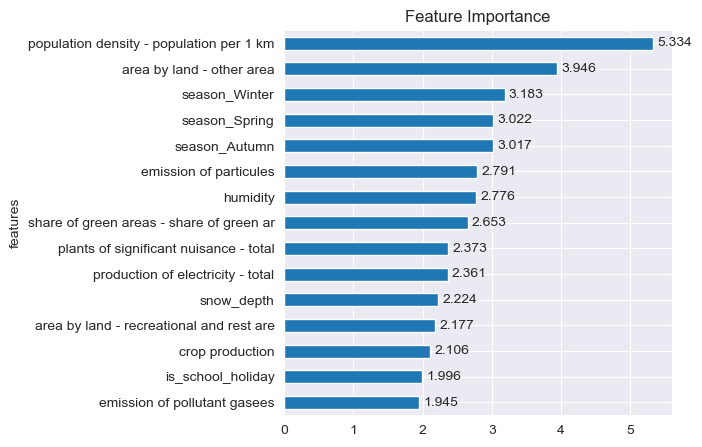

In [163]:
import matplotlib.pyplot as plt

#Creating a dataframe for feature importance
feat_imp_df = \
pd.DataFrame({
    'features': top_features[:15],
    'importance': np.round(top_feature_values[:15], 3)
}).set_index('features').sort_values('importance')

ax = feat_imp_df.plot(kind='barh', figsize=(5, 5))
ax.set_title("Feature Importance");
ax.bar_label(ax.containers[0], padding=3);
ax.legend().remove()
ax.figure.savefig('most_important_features_is_urban.png', facecolor="white", bbox_inches='tight')
plt.show()

In [77]:
del(df)

#### Model evaluation

In [15]:
df_test = pd.read_parquet('../../data/8. data_for_modelling/Non Temporal Datasets/test_nontemporal_classification.parquet.gz')

In [16]:
df_test = (df_test.pipe(encodeCategoricalFeatures)
      .pipe(encodeTargetVariable)
      .pipe(groupFeatures)
      .pipe(dropFeatures)
      )

In [17]:
X_test_df = df_test.drop('CAQI_level', axis=1)
Y_test_df = df_test['CAQI_level']

In [18]:
X_test_df = (X_test_df.pipe(scaleTransformX))

In [19]:
X_test = X_test_df.values
y_test = Y_test_df.values

In [20]:
y_pred = lr.predict(X_test)

In [21]:
# Evaluating the model performance
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.67      0.68     31913
           1       0.55      0.60      0.57     24346
           2       0.40      0.28      0.33      3683
           3       0.30      0.16      0.21       448

    accuracy                           0.61     60390
   macro avg       0.48      0.43      0.45     60390
weighted avg       0.61      0.61      0.61     60390



In [22]:
lr.score(X_test, y_test) # 0.612502069879119

0.612849809571121

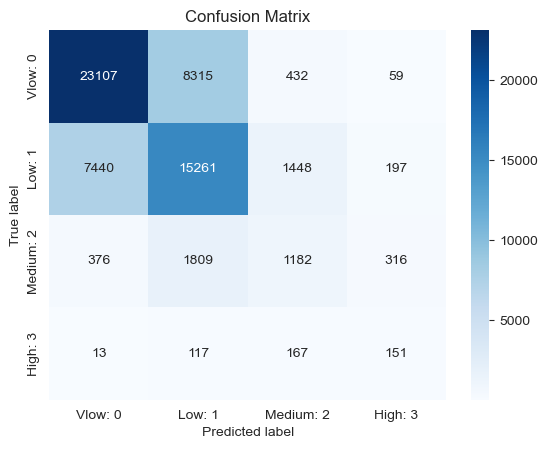

In [119]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

# Class labels
class_names = ['Vlow: 0', 'Low: 1', 'Medium: 2', 'High: 3']

# Heatmap plot of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Plot labels and title
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()